## prepare data
20 subjects in total, 18 will be used for training and validation, 2 will be used for independent testing
raw images in nifti format, conver to png format, in order to use the existing augmentation solution. 

In [86]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt 
import torch.nn as nn
from PIL import Image
import torch.nn as nn

In [2]:
from fastai.data.all import *
from fastai.vision.all import *

In [3]:
#nii folder has orig/label images in nifti format, orig and label would have corresponding images in png formats
train_path = Path('./data/train/') 
test_path = Path('./data/test/') 

In [4]:
def nii2png(nii_path, png_path_orig, png_path_label):
    '''convert nii images to png files, and save original images to png_path_orig, and labeled  images to png_path_label'''
    os.system('if [ ! -d {imgdir} ]; then mkdir -p {imgdir} ; fi;'.format(imgdir = png_path_orig))
    os.system('if [ ! -d {imgdir} ]; then mkdir -p {imgdir} ; fi;'.format(imgdir = png_path_label))
    
    nifti_images = sorted(get_files(nii_path,extensions='.gz')) #all nifti images under folder: data/train/nii 
    
    label_images = nifti_images[::2]
    raw_images = nifti_images[1::2]
    
    
    for (raw,label) in zip(raw_images, label_images):
        sub_name = raw.stem[:10] #substr, e.g., ircad_e01_ 
        raw_data = nib.load(raw,).get_fdata().astype(np.uint8) #intensity within [0.255]
        label_data = nib.load(label).get_fdata().astype(np.uint8)
        
        assert raw_data.shape == label_data.shape  
        
        print('working on subject : {}'.format(sub_name[:-1])) 
        for idx in range(raw_data.shape[2]):
            orig_name = sub_name + '{:03}.png'.format(idx) #e.g., ircad_e01_000.png
            label_name = sub_name + '{:03}L.png'.format(idx) #e.g., ircad_e01_000L.png
            Image.fromarray(raw_data[:,:,idx]).save(png_path_orig/orig_name)
            Image.fromarray(label_data[:,:,idx]).save(png_path_label/label_name)  

In [5]:
# for training and validation; 
nii2png(nii_path = train_path/'nii',png_path_orig = train_path/'orig', png_path_label=train_path/'label')  

working on subject : ircad_e01
working on subject : ircad_e02
working on subject : ircad_e03
working on subject : ircad_e04
working on subject : ircad_e05
working on subject : ircad_e06
working on subject : ircad_e07
working on subject : ircad_e08
working on subject : ircad_e09
working on subject : ircad_e10
working on subject : ircad_e11
working on subject : ircad_e12
working on subject : ircad_e13
working on subject : ircad_e14
working on subject : ircad_e15
working on subject : ircad_e16
working on subject : ircad_e17
working on subject : ircad_e18


In [6]:
# for independent testing; 
nii2png(nii_path = test_path/'nii',png_path_orig = test_path/'orig', png_path_label=test_path/'label')  

working on subject : ircad_e19
working on subject : ircad_e20


## verify images

In [5]:
def show_pair_overlay(seg, raw, alpha = 0.7):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(raw, cmap='gray')
    ax2.imshow(raw, cmap='jet')
    ax2.imshow(seg, cmap='gray', interpolation='none', alpha=alpha)
    return f, (ax1, ax2)

(<Figure size 640x480 with 2 Axes>, (<AxesSubplot: >, <AxesSubplot: >))

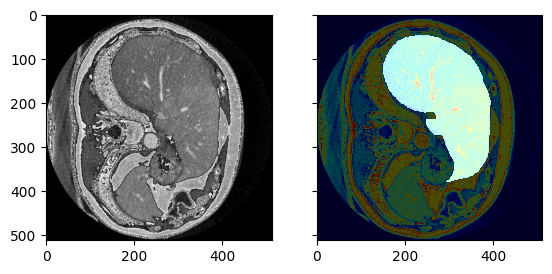

In [6]:
#verify training dataset
orig = Image.open('data/train/orig/ircad_e01_104.png'); 
label = Image.open('data/train/label/ircad_e01_104L.png')
show_pair_overlay(label, orig, alpha = 0.7)

(<Figure size 640x480 with 2 Axes>, (<AxesSubplot: >, <AxesSubplot: >))

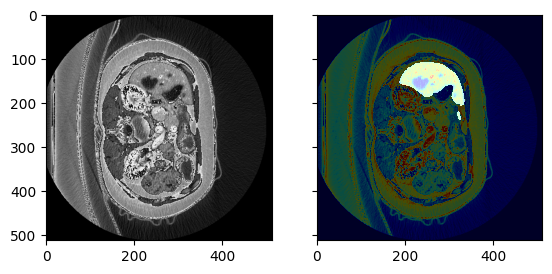

In [7]:
#verify testing dataset
orig = Image.open('data/test/orig/ircad_e19_041.png'); 
label = Image.open('data/test/label/ircad_e19_041L.png')
show_pair_overlay(label, orig, alpha = 0.7)

## DataLoaders 

In [8]:
path = Path('./')
dls = SegmentationDataLoaders.from_label_func(
    path, bs=4, fnames = get_image_files(path/'data/train/orig'),
    label_func = lambda o: path/'data/train/label'/f'{o.stem}L{o.suffix}', #liver images are put at data/label, with 'L' appended to the original name
    img_cls=PILImageBW,#only one channel, gray, not rgb; 
    item_tfms=RandomResizedCrop(256, min_scale=0.3), # works on each pair of (orig,label) 
    batch_tfms=aug_transforms(flip_vert=True) # works on each batch
)

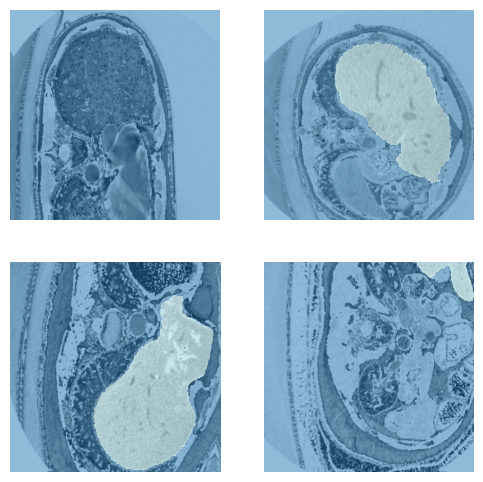

In [9]:
dls.show_batch() 

In [11]:
#check batch dims
x,y = dls.train.one_batch()
x.shape, y.shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 256, 256]))

## vanilla unet
build and test the vanilla unet with pytorch

In [134]:
def conv_block(ni, nf, kernel_size =3, padding = 1): 
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=kernel_size, padding=padding),
        nn.ReLU(inplace=True),
        nn.Conv2d(nf, nf, kernel_size=kernel_size, padding=padding),
        nn.ReLU(inplace=True)
    )

class VanillaUnet(nn.Module):
    
    def __init__(self, ni=1, ks=3, padding =1):
        
        super().__init__()        
        self.lconv1 = conv_block(ni, 32, ks, padding)
        self.lconv2 = conv_block(32, 64, ks, padding)
        self.lconv3 = conv_block(64, 128, ks, padding)
        self.lconv4 = conv_block(128, 256, ks, padding)
        self.lconv5 = conv_block(256, 512, ks, padding)
        
        self.rconv5 = conv_block(32, 2, ks, padding)
        self.rconv4 = conv_block(64+32, 32, ks, padding)
        self.rconv3 = conv_block(128+64, 64, ks, padding)
        self.rconv2 = conv_block(256+128, 128, ks, padding)
        self.rconv1 = conv_block(512+256, 256, ks, padding)
        
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self, x):        
        conv1 = self.lconv1(x)
        conv2 = self.lconv2(self.maxpool(conv1))
        conv3 = self.lconv3(self.maxpool(conv2))
        conv4 = self.lconv4(self.maxpool(conv3))
        x = self.lconv5(self.maxpool(conv4))
        
        x = torch.cat([self.upsample(x),conv4], dim=1)
        x = self.rconv1(x)        
        x = torch.cat([self.upsample(x),conv3], dim=1)
        x = self.rconv2(x)      
        x = torch.cat([self.upsample(x),conv2], dim=1)
        x = self.rconv3(x)  
        x = torch.cat([self.upsample(x),conv1], dim=1)
        x = self.rconv4(x)  
        
        out = self.rconv5(x)         
        return out

In [135]:
loss_func=CrossEntropyLossFlat(axis=1)
learn_vun = Learner( dls, VanillaUnet(), lr=1e-3, opt_func = Adam, loss_func = CrossEntropyLossFlat(axis=1), metrics=Dice(),moms=(0.95,0.85,0.95))

In [136]:
learn_vun.summary()

VanillaUnet (Input shape: 4 x 1 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 32 x 256 x 256  
Conv2d                                    320        True      
ReLU                                                           
Conv2d                                    9248       True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 128 x 128  
Conv2d                                    18496      True      
ReLU                                                           
Conv2d                                    36928      True      
ReLU                                                           
____________________________________________________________________________
                     4 x 128 x 64 x 64   
Conv2d                                    73856      True      
ReLU                               

In [129]:
learn_vun.fit_one_cycle(10) # the vanilla model seems to work well, though converged slowly

epoch,train_loss,valid_loss,dice,time
0,0.186913,0.142511,0.625639,00:39
1,0.188649,0.172030,0.569596,00:39
2,0.147884,0.095943,0.731067,00:39
3,0.136926,0.106599,0.569637,00:39
4,0.110400,0.059854,0.878235,00:39
5,0.105317,0.058033,0.877891,00:39
6,0.101902,0.056527,0.877432,00:39
7,0.083842,0.045910,0.915778,00:39
8,0.077015,0.043958,0.921298,00:39
9,0.069335,0.042334,0.922154,00:39


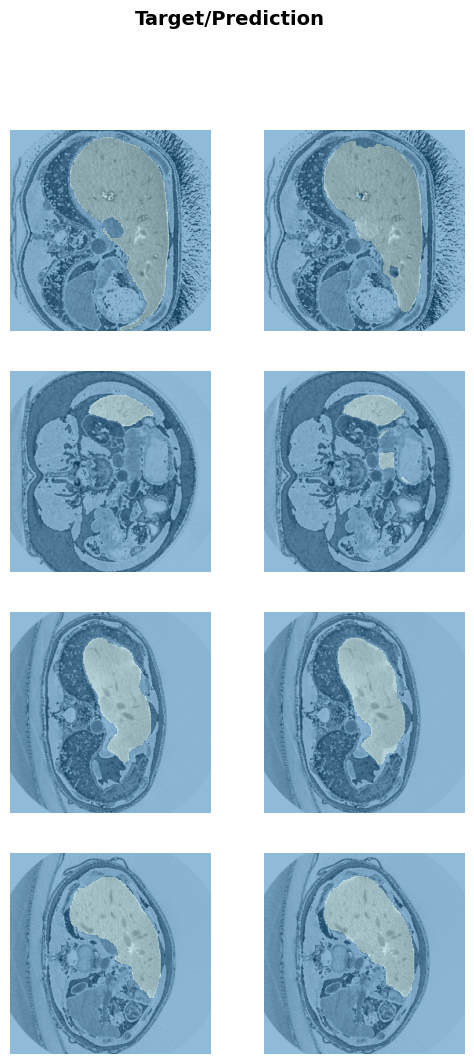

In [132]:
learn_vun.show_results() 

## unet with pretrained resnet

In [8]:
loss_func = CrossEntropyLossFlat(axis=1) #softmax over the channel dim
learn = unet_learner(dls, resnet34, n_in = 1, n_out=2, opt_func = Adam, loss_func = loss_func, metrics=Dice())

In [16]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [9]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,dice,time
0,0.162815,0.078982,0.811617,01:08


epoch,train_loss,valid_loss,dice,time
0,0.064125,0.027078,0.935813,01:13
1,0.072469,0.033221,0.935469,01:13
2,0.045283,0.018526,0.955878,01:14
3,0.042010,0.015968,0.961060,01:13
4,0.029340,0.016664,0.960576,01:13
5,0.026643,0.013145,0.966771,01:13
6,0.022538,0.013282,0.967202,01:14
7,0.019160,0.011661,0.969599,01:14
8,0.017385,0.010549,0.972164,01:13
9,0.015652,0.010487,0.972452,01:13


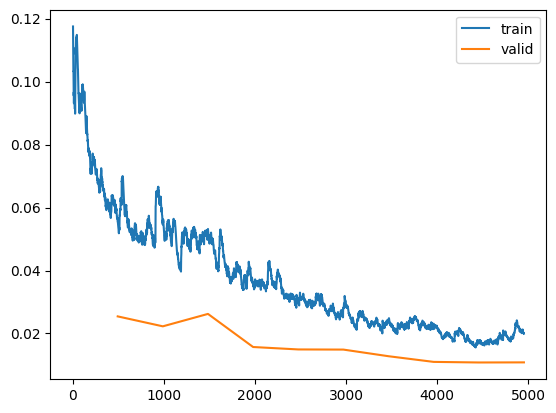

In [145]:
learn.recorder.plot_loss() #seems to converge and a few more epochs would be better. 

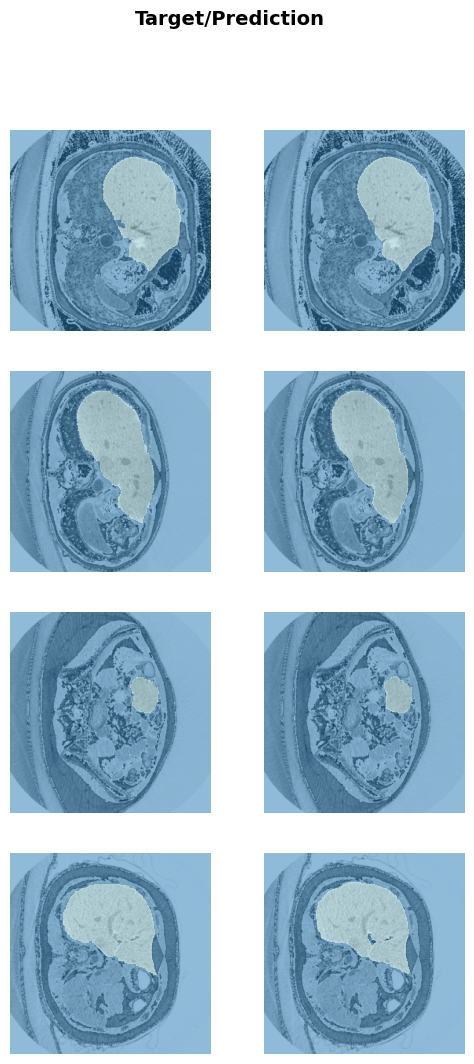

In [23]:
learn.show_results()

In [12]:
mdl_name = 'unet-resnet34-liverseg'

In [11]:
learn.save(mdl_name) # target: path/models/mdl_name

Path('models/unet-resnet34-liverseg.pth')

## predict on independent testing dataset 

In [24]:
def dice_coef(y_true, y_pred, eps=1e-8):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return ((2. * intersection + eps) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + eps)).item()

In [10]:
path = Path('./')
dlsT = SegmentationDataLoaders.from_label_func(
    path, bs=4, fnames = get_image_files(path/'data/test/orig'),
    valid_pct = 0.99, #
    label_func = lambda o: path/'data/test/label'/f'{o.stem}L{o.suffix}',  
    img_cls=PILImageBW,#only one channel, gray, not rgb; 
    #item_tfms=Resize(256, method=ResizeMethod.Squish), # change to this resize reduces the performance slightly
    item_tfms=RandomResizedCrop(256, min_scale=0.3), # works on each pair of (orig,label) 
)

In [13]:
loss_func = CrossEntropyLossFlat(axis=1) #softmax over the channel dim
test = unet_learner(dlsT, resnet34, n_in = 1, n_out=2, opt_func = Adam, loss_func = loss_func, metrics=Dice()) #
test.load(mdl_name)

In [8]:
test.freeze()

In [9]:
_, test_dice = test.validate()
print('independent testing subjects, dice: {:6f}'.format(test_dice))

independent testing subjects, dice: 0.951924


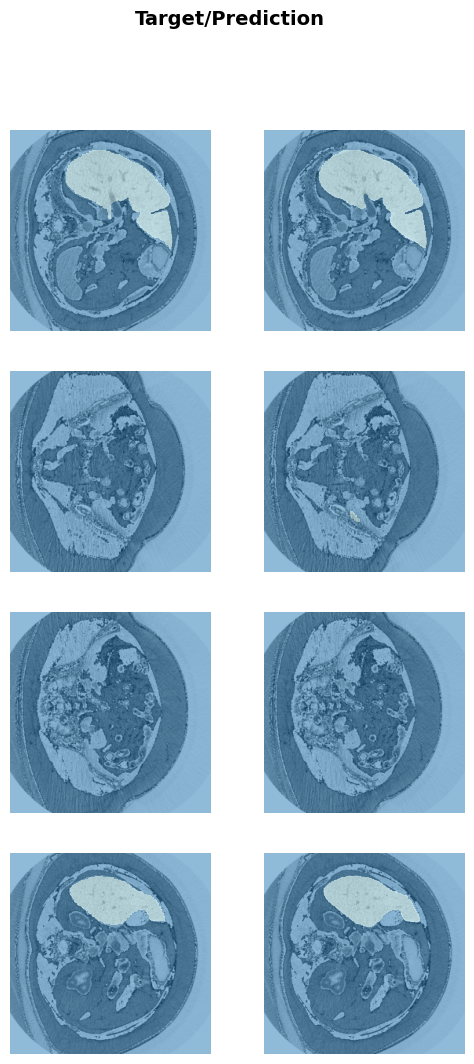

In [38]:
test.show_results()